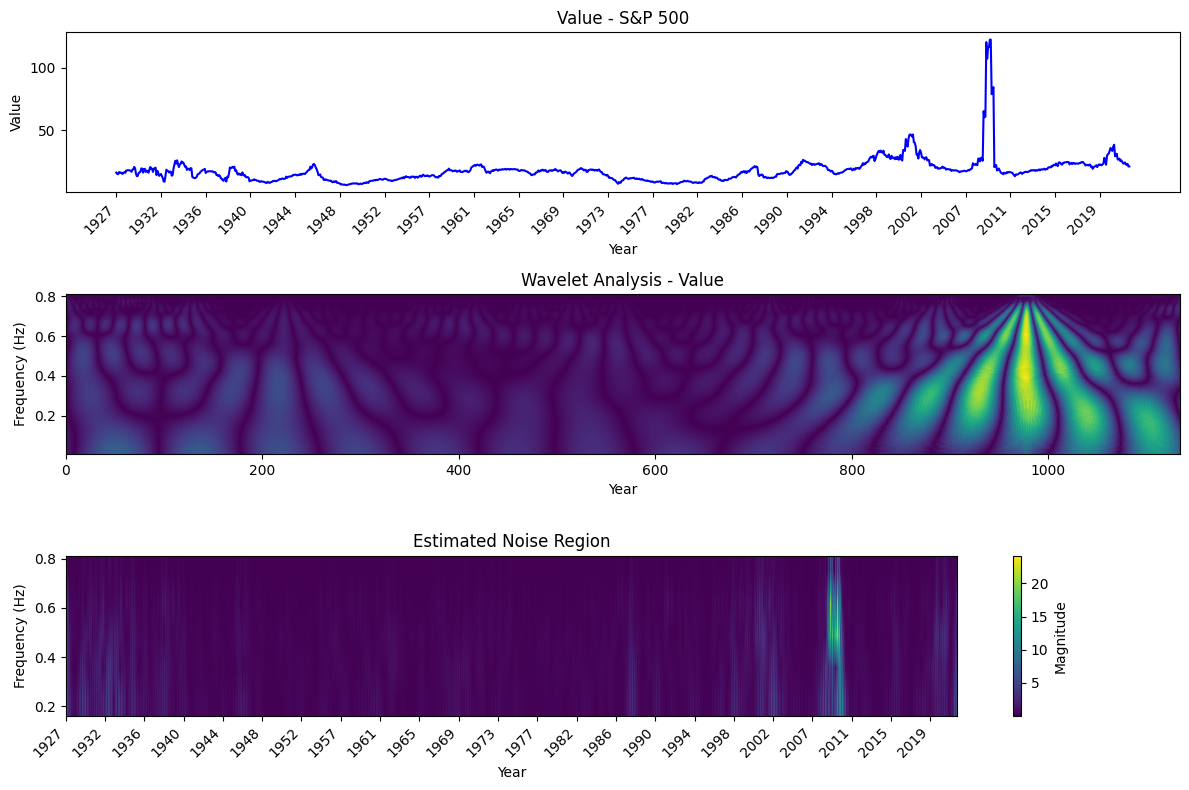

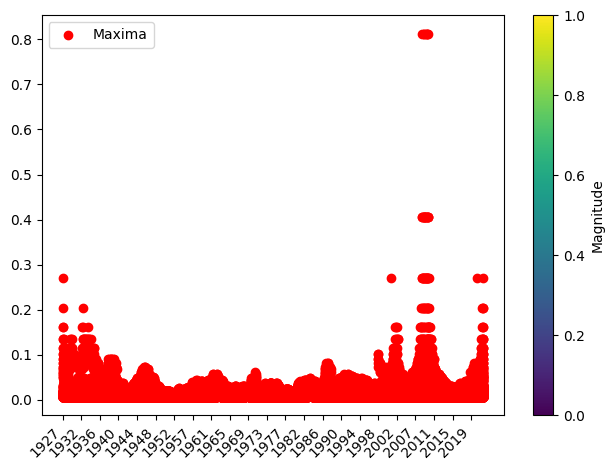

In [16]:
import pandas as pd
import pywt
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import factorial  # Import factorial function

# Function for noise estimation
def estimate_noise_std(coefficients, scales):
    low_activity_scales = scales[:5]
    noise_region = coefficients[:5, :]
    noise_std = np.std(noise_region)
    return noise_std, noise_region

# Function for Morse wavelet
def morse_wavelet(t, beta, gamma):
    return (2**(beta/gamma)) * (gamma**(beta)) * t**(beta - 1) * \
           np.exp(-gamma * t) * np.exp(-0.5 * t**2) / factorial(beta - 1)

# Function for maxima detection
def find_maxima(coefficients, scales, noise_std=None, percentile_threshold=None):
    maxima_points = []

    if noise_std:
        threshold = noise_std * 3
        maxima_points = np.where(np.abs(coefficients) > threshold)

    elif percentile_threshold:
        threshold = np.percentile(np.abs(coefficients), percentile_threshold)
        maxima_points = np.where(np.abs(coefficients) > threshold)

    else:
        print("Error: Specify either a noise_std or percentile_threshold")

    return maxima_points

# Step 1: Read Excel data into a DataFrame
file_path = 'sp_500.xlsx'  # Replace with your file path
df = pd.read_excel(file_path)

# Step 2: Specify the wavelet function
wavelet = 'morl'  # Use the Morlet wavelet

# Step 3: Extract data for the entire dataset
pe_ratio_values = df['value'].tolist()
years = pd.to_datetime(df['Date']).dt.year.tolist()

# Perform wavelet analysis
coeffs, freqs = pywt.cwt(pe_ratio_values, scales=np.arange(1, 128), wavelet=wavelet)

# Noise estimation
noise_std, noise_region = estimate_noise_std(coeffs, freqs)

# Maxima detection
maxima_points = find_maxima(coeffs, freqs, noise_std=noise_std)

# Create common x-values for plotting
x_values = np.arange(len(pe_ratio_values))

# Plot the wavelet analysis results
plt.figure(figsize=(12, 8))

# Plot the original PE ratio with years on the x-axis
plt.subplot(3, 1, 1)
plt.plot(x_values, pe_ratio_values, color='blue')
plt.title('Value - S&P 500')
plt.xlabel('Year')
plt.ylabel('Value')
plt.xticks(x_values[::50], years[::50], rotation=45, ha='right')  # Show every 50th year for better visibility

# Plot the wavelet coefficients
plt.subplot(3, 1, 2)
plt.imshow(np.abs(coeffs), aspect='auto', extent=[0, len(pe_ratio_values), freqs[-1], freqs[0]], cmap='viridis', interpolation='bilinear')
plt.title('Wavelet Analysis - Value')
plt.xlabel('Year')
plt.ylabel('Frequency (Hz)')

# Plot the estimated noise region
plt.subplot(3, 1, 3)
plt.imshow(np.abs(noise_region), aspect='auto', extent=[0, len(pe_ratio_values), freqs[4], freqs[0]], cmap='viridis', interpolation='bilinear')
plt.title('Estimated Noise Region')
plt.xlabel('Year')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Magnitude')
plt.xticks(x_values[::50], years[::50], rotation=45, ha='right')  # Show every 50th year for better visibility

plt.tight_layout()
plt.show()

# Mark maxima points on the plot if any are found
if maxima_points:
    plt.scatter(maxima_points[1], freqs[maxima_points[0]], color='red', marker='o', label='Maxima')

# Adjust x-axis ticks and labels
plt.xticks(x_values[::50], years[::50], rotation=45, ha='right')

plt.colorbar(label='Magnitude')
plt.legend()

plt.tight_layout()
plt.show()


